In [11]:
import os
from utils import DataSeq, load_pickle_mv, load_ids

import numpy as np
import pandas as pd
import skimage.io as io

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.losses import Loss

from imblearn.over_sampling import RandomOverSampler

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [12]:
pkl_path = "./mv.pkl"
images_path = "./Train_non_experts_simple/"
test_path = "./Test/"
batch_size = 8
epochs = 10

In [14]:
X_train, y_train = load_pickle_mv(pkl_path, images_path)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
print(X_train.shape, y_train.shape)

test_ids, test_labels = load_ids(test_path)
test_ids, test_labels = shuffle(test_ids, test_labels, random_state=42)
print(test_ids.shape, test_labels.shape)

(75243,) (75243, 3)
(4364,) (4364, 3)


In [15]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train.reshape(-1, 1), y_train)
X_train_over = X_train_over.flatten()

count = 0
for i in range(len(X_train_over)):
    # Compare path label vs y_train_over label
    if np.argmax(y_train_over[i]) != int(X_train_over[i][27]) - 1:
        count += 1

print(f"Cases where majority voting differs from ground truth label: {count}/{len(X_train_over)}")

Cases where majority voting differs from ground truth label: 9379/108651


In [17]:
train_seq = DataSeq(X_train_over, y_train_over)
valid_seq = DataSeq(test_ids, test_labels)

train_steps = len(X_train) // batch_size
valid_steps = len(test_ids) // batch_size

# Hyperparameter Tuning

In [18]:
def build_model():
    input_layer = Input(shape=(224, 224, 3))

    data_augmentation = tf.keras.Sequential([
        input_layer,
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.15),
    ])
    
    vgg = tf.keras.applications.VGG16(weights=None, include_top=False, input_tensor=data_augmentation.output)
    vgg.load_weights('./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg.trainable = False

    model = vgg.output
    model = Flatten()(model)
    model = Dense(4096, activation='relu')(model)
    model = Dropout(0.25)(model)

    model = Dense(3, activation='softmax')(model)

    model = Model(input_layer, model, name="Transfer_VGG16")
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [19]:
model = build_model()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_seq, validation_data=valid_seq, steps_per_epoch=train_steps,
    validation_steps=valid_steps, epochs=10, callbacks=[stop_early])

Epoch 1/10


2023-10-11 09:41:51.801050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-11 09:41:53.156034: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-11 09:41:53.823726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-11 09:41:53.841665: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b5fa877670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-11 09:41:53.841704: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-10-11 09:41:53.872210: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-11 09:41:54.06331

9405/9405 [==============================] - 481s 51ms/step - loss: 0.6585 - accuracy: 0.7604 - val_loss: 0.6475 - val_accuracy: 0.7491
Epoch 2/10
9405/9405 [==============================] - 476s 51ms/step - loss: 0.5390 - accuracy: 0.7778 - val_loss: 0.5786 - val_accuracy: 0.7938
Epoch 3/10
9405/9405 [==============================] - 476s 51ms/step - loss: 0.5285 - accuracy: 0.7835 - val_loss: 0.5586 - val_accuracy: 0.7807
Epoch 4/10
9405/9405 [==============================] - 476s 51ms/step - loss: 0.5181 - accuracy: 0.7894 - val_loss: 0.4703 - val_accuracy: 0.8234
Epoch 5/10
9405/9405 [==============================] - 480s 51ms/step - loss: 0.5130 - accuracy: 0.7905 - val_loss: 0.5378 - val_accuracy: 0.8023
Epoch 6/10
9405/9405 [==============================] - 480s 51ms/step - loss: 0.5059 - accuracy: 0.7929 - val_loss: 0.6845 - val_accuracy: 0.7177
Epoch 7/10
9405/9405 [==============================] - 477s 51ms/step - loss: 0.4995 - accuracy: 0.7951 - val_loss: 0.4962 - val

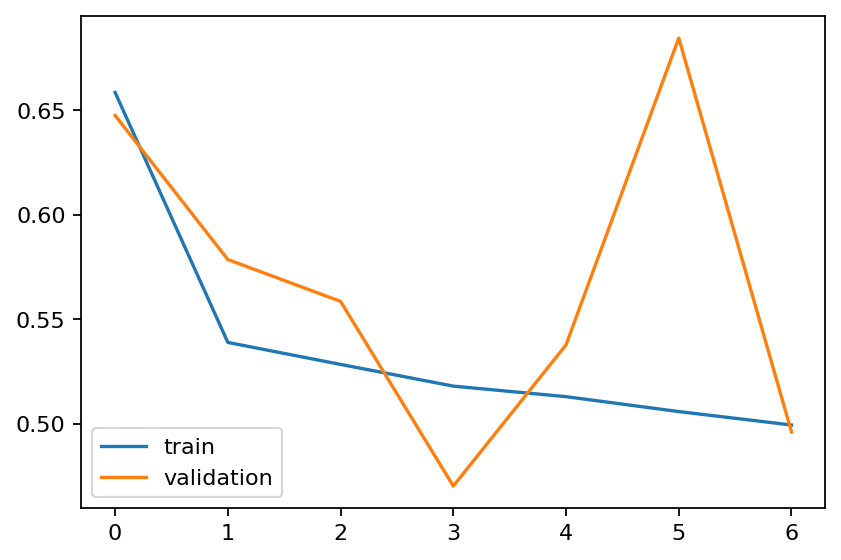

In [20]:
plt.figure(figsize=(6, 4), dpi=160)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.show()

In [22]:
y_pred = model.predict(valid_seq)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(np.argmax(test_labels, axis=1), y_pred))

546/546 [==============================] - 18s 33ms/step
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2692
           1       0.84      0.60      0.70      1196
           2       0.57      0.89      0.69       476

    accuracy                           0.81      4364
   macro avg       0.76      0.80      0.76      4364
weighted avg       0.83      0.81      0.81      4364



In [23]:
 model.save_weights('./bcss_aug_weights_mv_cce_os.h5')